In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [76]:
img = cv2.imread('assets/cat.jpg', cv2.IMREAD_GRAYSCALE) 

print("maxtrix output:")
print(img)

maxtrix output:
[[ 67  63  78 ... 159 159 158]
 [ 65  71  74 ... 158 157 156]
 [ 75  75  72 ... 159 159 159]
 ...
 [ 75  72  82 ... 156 151 150]
 [ 80  75  75 ... 153 152 158]
 [ 79  78  79 ... 153 156 154]]


ReLU Layer

In [77]:
class ReLULayer:
    def apply_relu(self, input_data):
        return np.maximum(0, input_data)

Convolutional Layer

Size: (1, 998, 998)


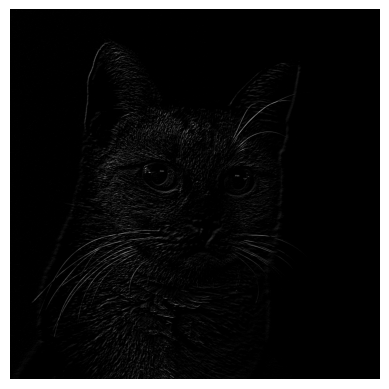

In [91]:
class ConvolutionLayer:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        # Random kernel entropy
        self.filters = np.random.randn(num_filters, filter_size, filter_size)  
    
    def apply_filter(self, image):
        image_height, image_width = image.shape
        filter_height, filter_width = self.filter_size, self.filter_size
        
        output_height = image_height - filter_height + 1 
        output_width = image_width - filter_width + 1 
        
        output = np.zeros((self.num_filters, output_height, output_width))
        
        for f in range(self.num_filters):
            for i in range(output_height):
                for j in range(output_width):
                    #Apply filter
                    region = image[i:i + filter_height, j:j + filter_width]
                    output[f, i, j] = np.sum(region * self.filters[f])
        return output

conv_layer = ConvolutionLayer(num_filters=1, filter_size=3)
conv_output = conv_layer.apply_filter(img)

relu_layer = ReLULayer()
relu_output = relu_layer.apply_relu(conv_output)

print("Size:", relu_output.shape)

plt.imshow(relu_output.squeeze(0), cmap='gray')
plt.axis('off') 
plt.show()


Max Pooling Layer

Size (1, 499, 499)


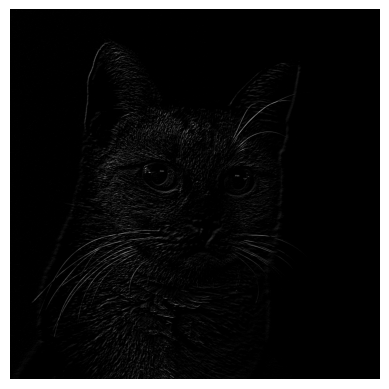

In [92]:
class MaxPoolingLayer:
    def __init__(self, pool_size=(2, 2), stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def apply(self, input_matrix):
        (N, H, W) = input_matrix.shape
        pool_height, pool_width = self.pool_size
        
        pooled_H = (H - pool_height) // self.stride + 1
        pooled_W = (W - pool_width) // self.stride + 1
        
        output_matrix = np.zeros((N, pooled_H, pooled_W))
        
        for n in range(N):
            for i in range(pooled_H):
                for j in range(pooled_W):
                    h_start = i * self.stride
                    w_start = j * self.stride
                    h_end = h_start + pool_height
                    w_end = w_start + pool_width
                    output_matrix[n, i, j] = np.max(input_matrix[n, h_start:h_end, w_start:w_end]) #ROI
        
        return output_matrix

pooling_layer = MaxPoolingLayer(pool_size=(2, 2), stride=2)
pooling_ouput = pooling_layer.apply(relu_output)

print("Size",pooling_ouput.shape)

plt.imshow(relu_output.squeeze(0), cmap='gray')
plt.axis('off') 
plt.show()


Vector flattening

In [93]:
# flat the matrix
batch_size, pooled_H, pooled_W = pooling_ouput.shape
flattened_output = pooling_ouput.reshape(batch_size, -1)
print("flat vector:", flattened_output)


flat vector: [[20.63202984  0.          3.99681137 ...  0.          0.
   0.        ]]


FullyConnected Layer

In [94]:
class CustomDense:
    def __init__(self, units, activation=None):
        self.units = units
        self.activation = activation
        self.weights = None
        self.biases = None

    def build(self, input_shape):
        # random weight and bias scale should be between 0.01 to 0.1
        self.weights = np.random.randn(input_shape[1], self.units) * 0.01
        self.biases = np.random.randn(1, self.units) * 0.01

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        if self.activation:
            self.output = self.activation(self.output)
        return self.output

    @staticmethod
    def activation_fn(x):
        return np.maximum(0, x) 

dense_layer = CustomDense(units=128, activation=CustomDense.activation_fn)
dense_layer.build(flattened_output.shape)
output_fc = dense_layer.forward(flattened_output)
print("Size", output_fc.shape)
print(output_fc)


Size (1, 128)
[[  0.         215.14777578  71.73530857   0.          96.09765713
    0.           0.          46.48014195 375.04864318   3.74510257
    0.          44.31383345  16.09206923   3.17405572   0.
    0.           0.         169.14306413   0.          46.61213372
    0.           0.87930994   0.          83.80877721   0.
    0.           0.          49.5439118  166.51793228   0.
    0.           0.         116.97398867  67.16955648 212.55709954
   80.08791721   0.          42.41757327 127.39954051  22.10924957
   58.17711187 121.03516831  84.54591562 200.04838916  72.3204983
    0.          15.65129808  31.97787905   0.         314.9526123
   78.52678026  52.22546732   0.           8.45101543   0.
    0.         111.48304024   1.67925621 105.41018344  29.55481468
    0.           0.           0.           0.         262.83300375
  259.05119405 142.46726366 100.8099278    0.           0.
   40.66283211  76.48873119 234.11500328   8.70105602   0.
    0.         346.92976124   0

Softmax Layer

In [122]:
num_classes = 2 # cat, dog
num_samples = [[1 , 0]] # the actual (ground truth) for pictures

class CustomSoftmax:
    def forward(self, inputs):
        exps = np.exp(inputs - np.max(inputs, axis=-1, keepdims=True)) # Euler constant, use max to avoid large num like e^278 to large. 
        sums = np.sum(exps, axis=-1, keepdims=True)
        self.output = exps / sums
        return self.output

# create 2 newral for softmax, no activation 
dense_layer2 = CustomDense(units=num_classes, activation=None)
dense_layer2.build(output_fc.shape)
output_fc2 = dense_layer2.forward(output_fc)
# find the softmax 
softmax_layer = CustomSoftmax()
output_softmax = softmax_layer.forward(output_fc2)

print("Softmax output:")
print(output_softmax)
print(num_samples[0])


Softmax output:
[[0.30633599 0.69366401]]
[1, 0]


CrossEntropy Loss

In [124]:
class CustomCrossEntropyLoss:
    def compute(self, predictions, labels):
        # super small value or log(0) extremely negative
        epsilon = 1e-15 
        # make sure no value below epsilon and large than 1 - epsilon
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        loss = -np.mean(np.sum(labels * np.log(predictions), axis=-1)) # log-likelihood Cross-Entropy Loss
        return loss

loss_layer = CustomCrossEntropyLoss()

loss = loss_layer.compute(output_softmax, num_samples)

print("Cross-Entropy Loss:")
print(loss)

Cross-Entropy Loss:
1.183072779796612
